### Cell A — Imports & Config

In [1]:
# === Cell A — Imports, reproducibility, load balanced ROI manifest ===
import os, random
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import cv2
from tqdm.auto import tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

# Keep CPU threads tame
torch.set_num_threads(1)

root = Path("..").resolve()
data_dir = root / "data" / "wlasl_preprocessed"

# Use the specific balanced ROI manifest you showed
man_path = data_dir / "manifest_nslt2000_roi_top104_balanced_clean.csv"
assert man_path.exists(), f"Manifest not found: {man_path}"

df = pd.read_csv(man_path)
print("Loaded:", man_path)
print(f"Samples: {len(df)} | classes={df['gloss'].nunique()}")
print("Columns:", df.columns.tolist())

print("label_new min/max:", df["label_new"].min(), df["label_new"].max())
print("label_new nunique:", df["label_new"].nunique())

df.head()


Loaded: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/manifest_nslt2000_roi_top104_balanced_clean.csv
Samples: 1159 | classes=104
Columns: ['video_id', 'path', 'gloss', 'label', 'split', 'exists', 'label_new']
label_new min/max: 0 103
label_new nunique: 104


,video_id,path,gloss,label,split,exists,label_new
0,639,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0
1,624,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0
2,632,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0
3,623,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0
4,65009,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0


### Cell B — WLASLDataset (using ROI + label_new) + WLASLDataset with on-the-fly augmentations

In [2]:
# === Cell B — WLASLDataset (ROI, label_new) with safe loading + on-the-fly augmentation ===
import torch, numpy as np, cv2, decord, random
from torch.utils.data import Dataset
decord.bridge.set_bridge('torch')


def _resize_112(frame_tchw: torch.Tensor) -> torch.Tensor:
    T, C, H, W = frame_tchw.shape
    arr = frame_tchw.permute(0, 2, 3, 1).cpu().numpy()
    out = np.empty((T, 112, 112, C), dtype=np.float32)
    for t in range(T):
        out[t] = cv2.resize(arr[t], (112, 112), interpolation=cv2.INTER_AREA)
    return torch.from_numpy(out).permute(0, 3, 1, 2)


def _normalize(frame_tchw, mean=(0.45,)*3, std=(0.225,)*3):
    mean = torch.tensor(mean, dtype=frame_tchw.dtype, device=frame_tchw.device)[None, :, None, None]
    std  = torch.tensor(std,  dtype=frame_tchw.dtype, device=frame_tchw.device)[None, :, None, None]
    return (frame_tchw - mean) / std


def uniform_temporal_indices(n_total, clip_len, stride):
    if n_total <= 0:
        return [0] * clip_len
    wanted = (clip_len - 1) * stride + 1
    if n_total >= wanted:
        start = (n_total - wanted) // 2
        return [start + i * stride for i in range(clip_len)]
    idxs = [min(i * stride, n_total - 1) for i in range(clip_len)]
    return idxs


class WLASLDataset(Dataset):
    def __init__(self, df, clip_len=32, stride=2, train=False):
        self.df = df.reset_index(drop=True)
        self.clip_len = clip_len
        self.stride = stride
        self.train = train

    def __len__(self):
        return len(self.df)

    # --------- augmentation helpers (on-the-fly, train only) ---------
    def _augment(self, frames: torch.Tensor) -> torch.Tensor:
        """
        frames: [T, C, H, W], values in [0,1] (float32).
        Only applied when self.train == True.
        """
        if not self.train:
            return frames

        T, C, H, W = frames.shape

        # 1) Random horizontal flip
        if random.random() < 0.5:
            frames = torch.flip(frames, dims=[3])  # flip width

        # 2) Random Gaussian blur
        if random.random() < 0.3:
            k = random.choice([3, 5])
            fr_np = frames.permute(0, 2, 3, 1).cpu().numpy()  # [T,H,W,C]
            for t in range(T):
                fr_np[t] = cv2.GaussianBlur(fr_np[t], (k, k), 0)
            frames = torch.from_numpy(fr_np).permute(0, 3, 1, 2)

        # 3) Random brightness / contrast
        if random.random() < 0.3:
            alpha = 1.0 + 0.4 * (random.random() - 0.5)   # contrast ~ [0.8, 1.2]
            beta  = 0.1 * (random.random() - 0.5)         # brightness ~ [-0.05, 0.05]
            frames = frames * alpha + beta
            frames = frames.clamp(0.0, 1.0)

        # 4) Random cutout mask (simulate occlusion)
        if random.random() < 0.3:
            mask_size = random.randint(16, 40)
            y0 = random.randint(0, max(0, H - mask_size))
            x0 = random.randint(0, max(0, W - mask_size))
            frames[:, :, y0:y0+mask_size, x0:x0+mask_size] = 0.0

        return frames

    def _safe_load_clip(self, path: str) -> torch.Tensor:
        """
        Try to read a clip with decord. If anything fails, return a dummy zero clip.
        Returned shape: [T, C, H, W], float32 in [0,1].
        """
        try:
            vr = decord.VideoReader(path)
            n = len(vr)
            if n <= 0:
                raise RuntimeError("no frames")

            idxs = uniform_temporal_indices(n, self.clip_len, self.stride)
            batch = vr.get_batch(idxs)        # [T,H,W,C]
            x = batch.float() / 255.0         # [0,1]
            x = x.permute(0, 3, 1, 2)         # [T,C,H,W]
            x = _resize_112(x)                # [T,3,112,112]
            x = self._augment(x)              # on-the-fly aug (train only)
            x = _normalize(x)                 # final normalization
            return x
        except Exception as e:
            print(f"[WARN] Failed to read video {path}: {e} — using zero clip.")
            x = torch.zeros(self.clip_len, 3, 112, 112, dtype=torch.float32)
            x = _normalize(x)
            return x

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["path"]
        label = int(row["label_new"])   # contiguous 0..C-1

        x = self._safe_load_clip(path)
        return x, label, path


#### Cell C — Split DataFrames & DataLoaders (single worker)

In [3]:
# === Cell C — Splits + DataLoaders (no multiprocessing) ===

train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

print("Split sizes:", len(train_df), "train |", len(val_df), "val |", len(test_df), "test")

clip_len = 32
stride   = 2
batch_size = 4   # small to be safe on GPU

train_ds = WLASLDataset(train_df, clip_len=clip_len, stride=stride, train=True)
val_ds   = WLASLDataset(val_df,   clip_len=clip_len, stride=stride, train=False)
test_ds  = WLASLDataset(test_df,  clip_len=clip_len, stride=stride, train=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,              # 🔒 NO worker processes
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

x_dbg, y_dbg, _ = next(iter(train_loader))
print("Sample batch shape:", x_dbg.shape, "| labels range:", y_dbg.min().item(), "->", y_dbg.max().item())


Split sizes: 831 train | 192 val | 136 test
Device: cuda


Sample batch shape: torch.Size([4, 32, 3, 112, 112]) | labels range: 60 -> 88


#### Cell D Swap to R(2+1)D-18 (Kinetics-400)

In [4]:
# === Cell D — R(2+1)D-18 pretrained on Kinetics-400 ===

import torch.nn as nn
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights

# Number of classes from manifest
num_classes = df["label_new"].nunique()
print("num_classes:", num_classes)

# Load pretrained weights
weights = R2Plus1D_18_Weights.KINETICS400_V1
base = r2plus1d_18(weights=weights)

# Replace final FC for our 104 glosses
in_f = base.fc.in_features
base.fc = nn.Linear(in_f, num_classes)

# Move to device
model = base.to(device)
print("Model: r2plus1d_18_k400")


num_classes: 104
Model: r2plus1d_18_k400
Model: r2plus1d_18_k400


#### Cell E — Optimizer, Scaler, Loss

In [5]:
# === Cell E — Optimizer, scaler, loss (pretrained) ===
from torch.amp import GradScaler

epochs = 20
lr     = 1e-4      # 🔽 slightly lower than 3e-4 used for scratch
wd     = 1e-2
amp_on = True

opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = GradScaler(enabled=amp_on)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # can keep or remove smoothing
best_val_acc = -1.0


#### Cell F — run_epoch (with correct [B,C,T,H,W] permute)

In [6]:
# === Cell F — Metrics + epoch runner (for CNN+BiGRU) ===

def top1_acc(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_acc  = 0.0
    total_n    = 0

    opt.zero_grad(set_to_none=True)

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)  # [B,T,C,H,W]
        y = y.to(device, non_blocking=True)

        # 🔽 New: permute for 3D CNN
        x = x.permute(0, 2, 1, 3, 4).contiguous()  # [B,C,T,H,W]

        with torch.amp.autocast(device_type=device.type, enabled=amp_on):
            logits = model(x)
            loss = criterion(logits, y)

        if train:
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)

        with torch.no_grad():
            acc = top1_acc(logits, y)
            bs  = x.size(0)
            total_loss += loss.item() * bs
            total_acc  += acc * bs
            total_n    += bs

    return total_loss / total_n, total_acc / total_n



#### Cell G — Training Loop

In [7]:
# === Cell G — Training Loop ===
from pathlib import Path
import time

ckpt_dir = root / "checkpoints"
ckpt_dir.mkdir(exist_ok=True)

# notebook-based run identifier to prefix saved files
nb_stem = Path("06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18.ipynb").stem
nb_prefix = str(nb_stem).replace(' ', '_')
if 'run_tag' in globals():
    run_id = f"{nb_prefix}_{run_tag}"
else:
    run_id = f"{nb_prefix}_{time.strftime('%Y%m%dT%H%M%S')}"

best_val_acc = -1.0

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        # save both a full checkpoint and a plain model state_dict, both prefixed with the notebook/run id
        state = {
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optim_state': opt.state_dict() if 'opt' in globals() else None,
            'scaler_state': scaler.state_dict() if 'scaler' in globals() else None,
            'best_val_acc': best_val_acc,
        }
        full_path = ckpt_dir / f"{run_id}_best_full.pt"
        state_path = ckpt_dir / f"{run_id}_best_state.pt"
        torch.save(state, full_path)
        torch.save(model.state_dict(), state_path)
        print(f"  ➜ New best val acc={best_val_acc:.3f}; saved: {full_path}, {state_path}")


Epoch 01/20 | train loss 4.7727 acc 0.019 | val loss 4.5717 acc 0.036
  ➜ New best val acc=0.036; saved: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18_20251117T203217_best_full.pt, /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18_20251117T203217_best_state.pt
  ➜ New best val acc=0.036; saved: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18_20251117T203217_best_full.pt, /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18_20251117T203217_best_state.pt
Epoch 02/20 | train loss 4.3516 acc 0.075 | val loss 4.2023 acc 0.089
Epoch 02/20 | train loss 4.3516 acc 0.075 | val loss 4.2023 acc 0.089
  ➜ New best val acc=0.089; saved: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590

In [8]:
# === Cell: Load best checkpoint (prefixed) and run test ===
from pathlib import Path
import time

ckpt_dir = root / "checkpoints"
nb_stem = Path("06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18.ipynb").stem
nb_prefix = str(nb_stem).replace(' ', '_')
if 'run_tag' in globals():
    run_id = f"{nb_prefix}_{run_tag}"
else:
    # if training used a timestamped run_id, try to find any matching prefixed checkpoint
    run_id = None

candidates = []
if run_id is not None:
    candidates += [ckpt_dir / f"{run_id}_best_state.pt", ckpt_dir / f"{run_id}_best_full.pt"]
# fallbacks to older naming conventions
candidates += [ckpt_dir / f"{nb_prefix}_best_state.pt", ckpt_dir / f"{nb_prefix}_best_full.pt", ckpt_dir / 'best.pt', ckpt_dir / 'best_r2plus1d_k400_top104.pt']

best_path = None
for p in candidates:
    if p.exists():
        best_path = p
        break

if best_path is None:
    print('No checkpoint found among candidates:', candidates)
else:
    print('Loading checkpoint:', best_path)
    raw = torch.load(str(best_path), map_location=device if 'device' in globals() else 'cpu')

    # extract possible nested state dicts
    state_dict = None
    if isinstance(raw, dict):
        if 'model_state' in raw:
            state_dict = raw['model_state']
        elif 'state_dict' in raw:
            state_dict = raw['state_dict']
        else:
            # maybe it's already a plain state-dict (tensor values)
            keys = list(raw.keys())
            if keys and isinstance(raw[keys[0]], (torch.Tensor,)):
                state_dict = raw
    else:
        state_dict = raw

    if state_dict is None:
        raise RuntimeError(f'Could not find model parameters inside checkpoint: {best_path}')

    # try direct load then fallbacks similar to evaluation cell
    try:
        model.load_state_dict(state_dict)
    except Exception:
        # try non-strict load
        try:
            model.load_state_dict(state_dict, strict=False)
            print('Loaded with strict=False')
        except Exception:
            # attempt remap (module., _orig_mod.) then partial intersection
            def remap(sd, remove_prefix=None, add_prefix=None):
                out = {}
                for k, v in sd.items():
                    nk = k
                    if remove_prefix and nk.startswith(remove_prefix):
                        nk = nk[len(remove_prefix):]
                    if add_prefix:
                        nk = add_prefix + nk
                    out[nk] = v
                return out

            loaded = False
            ck_keys = list(state_dict.keys())
            mk = list(model.state_dict().keys())
            attempts = []
            if ck_keys and ck_keys[0].startswith('_orig_mod.'):
                attempts.append(remap(state_dict, remove_prefix='_orig_mod.'))
            if ck_keys and ck_keys[0].startswith('module.'):
                attempts.append(remap(state_dict, remove_prefix='module.'))
            if mk and mk[0].startswith('module.') and not (ck_keys and ck_keys[0].startswith('module.')):
                attempts.append(remap(state_dict, add_prefix='module.'))
            if mk and mk[0].startswith('_orig_mod.') and not (ck_keys and ck_keys[0].startswith('_orig_mod.')):
                attempts.append(remap(state_dict, add_prefix='_orig_mod.'))

            for cand in attempts:
                try:
                    model.load_state_dict(cand, strict=False)
                    state_dict = cand
                    loaded = True
                    print('Loaded after remapping keys.')
                    break
                except Exception:
                    pass

            if not loaded:
                # partial intersection
                model_sd = model.state_dict()
                intersect = {k: v for k, v in state_dict.items() if k in model_sd and v.shape == model_sd[k].shape}
                if not intersect:
                    raise RuntimeError('No matching keys between checkpoint and model after remapping attempts')
                model.load_state_dict(intersect, strict=False)
                print('Partial load applied (intersection of keys).')

    model.to(device if 'device' in globals() else 'cpu')

    # run test
    test_loss, test_acc = run_epoch(test_loader, train=False)
    print(f"TEST — loss {test_loss:.4f} | acc {test_acc:.3f}")


Loading checkpoint: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/best.pt
Loaded with strict=False
TEST — loss 3.4681 | acc 0.404
TEST — loss 3.4681 | acc 0.404


### Evaluation & Reports — test-set confusion matrix, per-class accuracy, and summary

This cell evaluates the best checkpoint (if present), computes a normalized confusion matrix for labels actually present in the test predictions/targets, per-class accuracy CSV, classification report (JSON & TXT), predictions CSV, and a JSON/TXT test summary. All saved files are prefixed with the notebook stem to avoid generic names.


No training history found; skipping curve plots.
Loading checkpoint: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/best.pt


Evaluating test set: 100%|██████████| 34/34 [00:03<00:00, 10.07it/s]



Test Top-1 accuracy: 0.4044 (N=136)


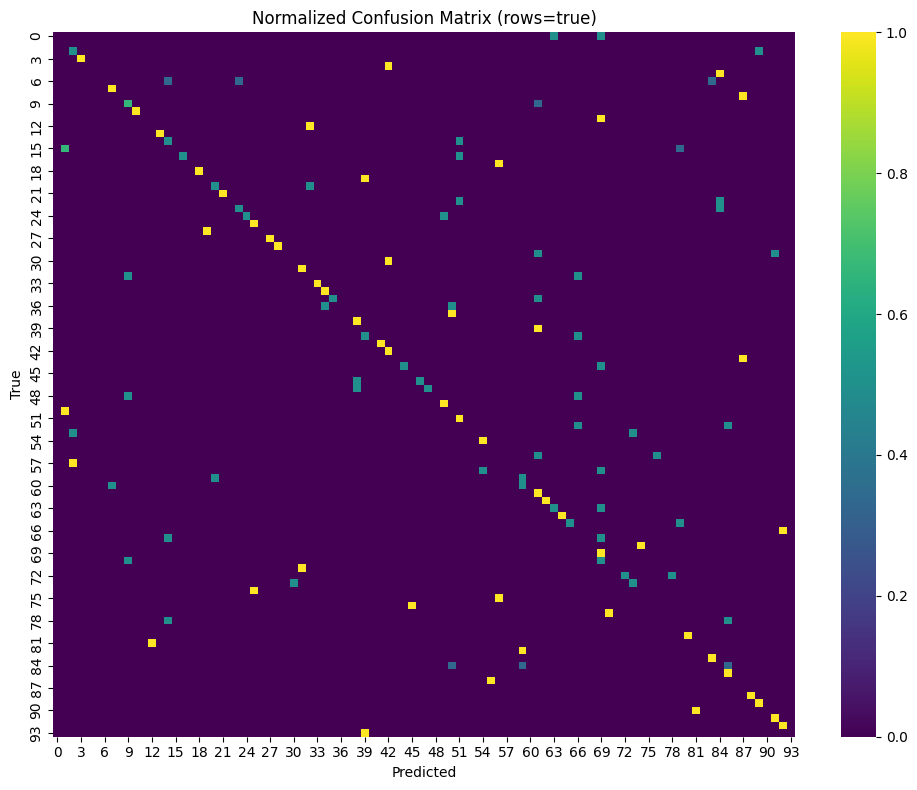

,label,gloss,accuracy,support
0,31,deaf,1.0,2
1,29,dark,1.0,2
2,27,cousin,1.0,2
3,70,room,1.0,2
4,55,laugh,1.0,2
5,46,good,1.0,2
6,79,soon,1.0,2
7,90,toast,1.0,2
8,101,year,1.0,2
9,15,brother,1.0,1



Saved classification report (json & txt) at: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18_20251117T204402_classification_report.json /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18_20251117T204402_classification_report.txt

Saved test report JSON and TXT to /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18_20251117T204402_test_report.json /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18_20251117T204402_test_report.txt


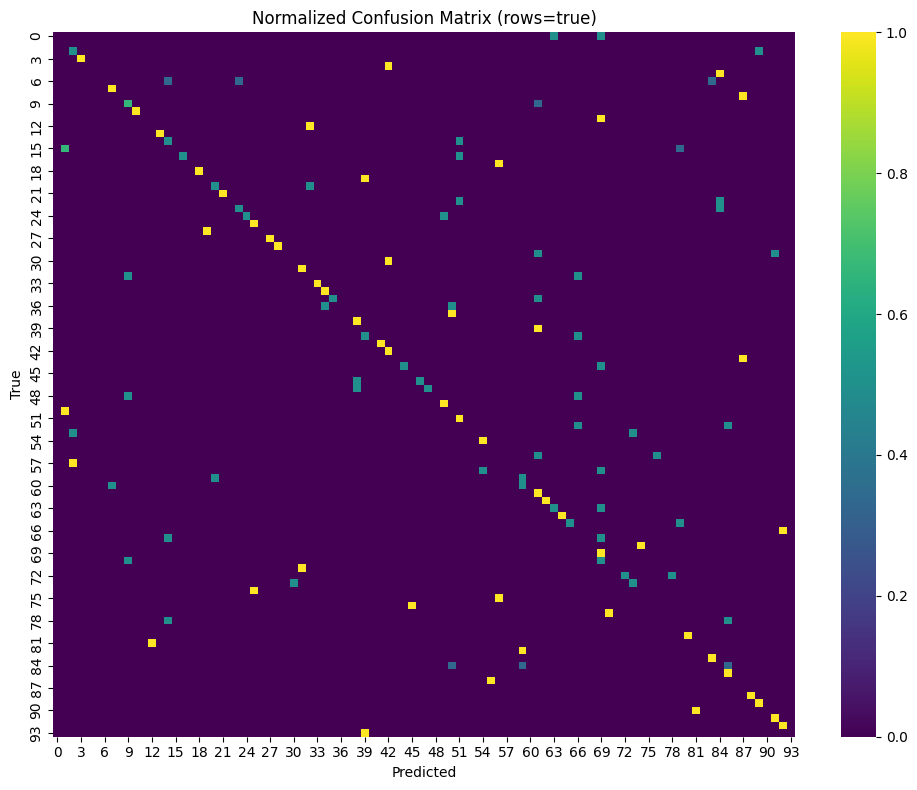

In [ ]:
# === Cell H — Evaluation, Plots and Test Report ===
"""
Evaluate the test set, compute normalized confusion matrix for present labels,
per-class accuracy CSV, classification report (json & txt), predictions CSV,
and a JSON/TXT test summary. Filenames prefixed with the notebook stem.
"""

import os, time, json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import torch
import torch.nn.functional as F

# directories and prefix
ckpt_dir = root / "checkpoints" if 'root' in globals() else Path('.') / 'checkpoints'
ckpt_dir.mkdir(parents=True, exist_ok=True)
report_dir = root / "reports" if 'root' in globals() else Path('.') / 'reports'
report_dir.mkdir(parents=True, exist_ok=True)
nb_stem = Path("06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18.ipynb").stem
nb_prefix = str(nb_stem).replace(' ', '_')

# create run identifier (prefer run_tag if present)
if 'run_tag' in globals():
    run_id = f"{nb_prefix}_{run_tag}"
else:
    stamp = time.strftime('%Y%m%dT%H%M%S')
    run_id = f"{nb_prefix}_{stamp}"

# Try to load history if any (this notebook might not persist history)
history = None
hist_candidates = [report_dir / f"{run_id}_history.json", report_dir / f"{nb_prefix}_history.json"]
for hp in hist_candidates:
    try:
        if hp.exists():
            with open(hp, 'r') as f:
                history = json.load(f)
            print('Loaded history from', hp)
            break
    except Exception:
        pass

# plot train/val curves if available
if history is not None:
    epochs_ran = len(history.get('train_loss', []))
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    axs[0].plot(range(1, epochs_ran+1), history.get('train_loss', []), label='train')
    axs[0].plot(range(1, epochs_ran+1), history.get('val_loss', []), label='val')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()

    axs[1].plot(range(1, epochs_ran+1), history.get('train_acc', []), label='train')
    axs[1].plot(range(1, epochs_ran+1), history.get('val_acc', []), label='val')
    axs[1].set_title('Top-1 Accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()

    plt.tight_layout()
    curves_path = report_dir / f"{run_id}_train_val_curves.png"
    plt.savefig(str(curves_path), dpi=150)
    display(fig)
else:
    print('No training history found; skipping curve plots.')

# find best model (prefer run-specific prefixed files)
best_path = None
# If run_id was present in the training session, prefer files that start with that prefix and contain 'best' or 'state'
if run_id is not None:
    # look for files that start with the run_id and contain 'best' or 'state' and pick the newest
    matches = list(ckpt_dir.glob(f"{run_id}*best*.pt")) + list(ckpt_dir.glob(f"{run_id}*_best*.pt")) + list(ckpt_dir.glob(f"{run_id}*state*.pt"))
    if matches:
        matches = sorted(matches, key=lambda p: p.stat().st_mtime)
        best_path = matches[-1]

# fallback candidates (older naming conventions)
if best_path is None:
    candidate_files = [
        ckpt_dir / f"{run_id}_best_state.pt",
        ckpt_dir / f"{run_id}_best_full.pt",
        ckpt_dir / f"{nb_prefix}_best_state.pt",
        ckpt_dir / f"{nb_prefix}_best_full.pt",
        ckpt_dir / f"{run_id}_best.pt",
        ckpt_dir / f"{nb_prefix}_best.pt",
        ckpt_dir / 'best.pt',
        ckpt_dir / 'best_r2plus1d_k400_top104.pt',
        ckpt_dir / 'best_r3d18_roi_top104.pt',
    ]
    for p in candidate_files:
        if p.exists():
            best_path = p
            break

if best_path is None:
    print('No checkpoint found among candidates; tried:', candidate_files)
    print('Skipping evaluation.')
else:
    print('Loading checkpoint:', best_path)
    raw = torch.load(str(best_path), map_location=device if 'device' in globals() else 'cpu')

    # Extract state_dict from common checkpoint containers
    state_dict = None
    if isinstance(raw, dict):
        if 'model_state' in raw:
            state_dict = raw['model_state']
        elif 'state_dict' in raw:
            state_dict = raw['state_dict']
        elif 'model' in raw and isinstance(raw['model'], dict):
            state_dict = raw['model']
        else:
            # sometimes the entire file is a state-dict-like mapping
            # detect if values are tensors
            keys = list(raw.keys())
            if keys and isinstance(raw[keys[0]], (torch.Tensor,)):
                state_dict = raw
    else:
        # raw may already be a state_dict
        state_dict = raw

    if state_dict is None:
        raise RuntimeError(f"Unable to locate model state_dict inside checkpoint: {best_path}")

    def try_load(sd, strict=False):
        try:
            model.load_state_dict(sd, strict=strict)
            return True, None
        except Exception as e:
            return False, e

    ok, err = try_load(state_dict, strict=False)
    if not ok:
        print('Direct load failed:', err)
        # attempt key remapping heuristics
        model_keys = list(model.state_dict().keys())
        ck_keys = list(state_dict.keys())

        def remap(sd, remove_prefix=None, add_prefix=None):
            out = {}
            for k, v in sd.items():
                nk = k
                if remove_prefix and nk.startswith(remove_prefix):
                    nk = nk[len(remove_prefix):]
                if add_prefix:
                    nk = add_prefix + nk
                out[nk] = v
            return out

        attempts = []
        # remove common wrapper prefixes
        if ck_keys and ck_keys[0].startswith('_orig_mod.'):
            attempts.append(('remove _orig_mod.', remap(state_dict, remove_prefix='_orig_mod.')))
        if ck_keys and ck_keys[0].startswith('module.'):
            attempts.append(('remove module.', remap(state_dict, remove_prefix='module.')))
        # add prefixes if model expects them
        if model_keys and model_keys[0].startswith('module.') and not ck_keys[0].startswith('module.'):
            attempts.append(('add module.', remap(state_dict, add_prefix='module.')))
        if model_keys and model_keys[0].startswith('_orig_mod.') and not ck_keys[0].startswith('_orig_mod.'):
            attempts.append(('add _orig_mod.', remap(state_dict, add_prefix='_orig_mod.')))

        loaded = False
        for desc, cand in attempts:
            ok2, err2 = try_load(cand, strict=False)
            print(f'Attempt {desc}:', 'OK' if ok2 else f'Failed: {err2}')
            if ok2:
                state_dict = cand
                loaded = True
                break

        if not loaded:
            # last resort: partial load by intersection
            print('Attempting partial load (intersection of keys).')
            model_sd = model.state_dict()
            intersect = {k: v for k, v in state_dict.items() if k in model_sd and v.shape == model_sd[k].shape}
            if not intersect:
                raise RuntimeError('No matching keys for partial load after all remapping attempts.')
            model.load_state_dict(intersect, strict=False)
            print('Partial load applied (some parameters may remain uninitialized).')

    # ensure model on device
    if 'device' in globals():
        model.to(device)
    model.eval()

    # --- run evaluation ---
    y_true = []
    y_pred = []
    paths = []
    losses = []

    with torch.no_grad():
        for x, y, pth in tqdm(test_loader, desc='Evaluating test set'):
            # dataset returns [T,C,H,W] — some models require [B,C,T,H,W]
            # this notebook's model is an r2plus1d variant that expects [B,C,T,H,W]
            x = x.to(device if 'device' in globals() else 'cpu', non_blocking=True)
            y = y.to(device if 'device' in globals() else 'cpu', non_blocking=True)

            # permute if needed (safe: if model already expects T,C ordering, you can remove this)
            try:
                x_for_model = x.permute(0, 2, 1, 3, 4).contiguous()
            except Exception:
                x_for_model = x

            with torch.amp.autocast(device_type=device.type if 'device' in globals() else 'cpu', enabled=globals().get('amp_on', False)):
                logits = model(x_for_model)
                loss = F.cross_entropy(logits, y)
                preds = logits.argmax(1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            paths.extend(pth)
            losses.extend([float(loss.cpu().item())] * x.size(0))

    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred, dtype=int)
    losses = np.array(losses, dtype=float)

    test_acc = float((y_true == y_pred).mean())
    print(f'Test Top-1 accuracy: {test_acc:.4f} (N={len(y_true)})')

    # label->gloss mapping
    label_to_name = None
    if 'df' in globals():
        if 'gloss' in df.columns and 'label_new' in df.columns:
            tmp = df.groupby('label_new')['gloss'].first().to_dict()
            label_to_name = {int(k): str(v) for k, v in tmp.items()}

    # ensure we only pass labels actually present
    present = sorted(set(np.unique(y_true)).union(set(np.unique(y_pred))))
    labels_list = [int(x) for x in present]
    names_list = [label_to_name.get(int(l), str(int(l))) if label_to_name is not None else str(int(l)) for l in labels_list]

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)

    fig, ax = plt.subplots(figsize=(10, 8))
    if len(labels_list) <= 50:
        sns.heatmap(cm_norm, xticklabels=names_list, yticklabels=names_list, cmap='viridis', vmin=0, vmax=1, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    else:
        sns.heatmap(cm_norm, cmap='viridis', vmin=0, vmax=1, ax=ax)
    ax.set_title('Normalized Confusion Matrix (rows=true)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.tight_layout()
    cm_path = report_dir / f"{run_id}_confusion_matrix_norm.png"
    plt.savefig(str(cm_path), dpi=150)
    display(fig)

    # per-class accuracy
    support = cm.sum(axis=1)
    per_class_acc = (cm.diagonal().astype('float') / (support + 1e-12))
    class_acc_df = pd.DataFrame({
        'label': labels_list,
        'gloss': names_list,
        'accuracy': per_class_acc,
        'support': support
    })
    class_acc_df = class_acc_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

    display(class_acc_df.head(20))
    per_class_csv = report_dir / f"{run_id}_per_class_accuracy.csv"
    class_acc_df.to_csv(str(per_class_csv), index=False)

    # classification report
    clf_report_dict = classification_report(y_true, y_pred, labels=labels_list, target_names=names_list, zero_division=0, output_dict=True)
    clf_report_txt = classification_report(y_true, y_pred, labels=labels_list, target_names=names_list, zero_division=0)

    clf_json_path = report_dir / f"{run_id}_classification_report.json"
    with open(str(clf_json_path), 'w') as f:
        json.dump(clf_report_dict, f, indent=2)

    clf_txt_path = report_dir / f"{run_id}_classification_report.txt"
    with open(str(clf_txt_path), 'w') as f:
        f.write(clf_report_txt)

    print('\nSaved classification report (json & txt) at:', clf_json_path, clf_txt_path)

    # predictions CSV
    preds_df = pd.DataFrame({'path': paths, 'y_true': y_true.tolist(), 'y_pred': y_pred.tolist()})
    if label_to_name is not None:
        preds_df['y_true_name'] = preds_df['y_true'].map(lambda x: label_to_name.get(int(x), str(int(x))))
        preds_df['y_pred_name'] = preds_df['y_pred'].map(lambda x: label_to_name.get(int(x), str(int(x))))
    else:
        preds_df['y_true_name'] = preds_df['y_true'].astype(str)
        preds_df['y_pred_name'] = preds_df['y_pred'].astype(str)

    preds_csv = report_dir / f"{run_id}_predictions.csv"
    preds_df.to_csv(str(preds_csv), index=False)

    # assemble report
    report = {
        'created_at': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()),
        'notebook': nb_prefix,
        'run_id': run_id,
        'best_checkpoint': str(best_path),
        'test_top1': float(test_acc),
        'n_samples': int(len(y_true)),
        'num_classes_present': int(len(labels_list)),
        'per_class_csv': str(per_class_csv),
        'confusion_matrix_png': str(cm_path),
        'classification_report_json': str(clf_json_path),
        'predictions_csv': str(preds_csv)
    }

    test_report_json = report_dir / f"{run_id}_test_report.json"
    with open(str(test_report_json), 'w') as f:
        json.dump(report, f, indent=2)

    test_report_txt = report_dir / f"{run_id}_test_report.txt"
    with open(str(test_report_txt), 'w') as f:
        f.write('Test report\n')
        f.write('Created: ' + report['created_at'] + '\n')
        f.write('Notebook: ' + report['notebook'] + '\n')
        f.write('Run: ' + report['run_id'] + '\n')
        f.write('Checkpoint: ' + report['best_checkpoint'] + '\n')
        f.write(f"Test Top1: {report['test_top1']} (N={report['n_samples']})\n")
        f.write(f"Num classes present: {report['num_classes_present']}\n")

    print('\nSaved test report JSON and TXT to', test_report_json, test_report_txt)